# Low Ratings Clustering Analysis
Analyzing clusters within low-rated board games (rating < 6.0).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Import clustering utilities
from cluster_utils import agglomerative_grid_search

# Set display options and styling
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

# Create output directory for plots if it doesn't exist
import os
if not os.path.exists('../plots'):
    os.makedirs('../plots')
if not os.path.exists('../frames'):
    os.makedirs('../frames')

In [2]:
# Load processed data
filtered_df = pd.read_csv('../frames/filtered_games.csv')
all_binary_cols = np.load('../frames/all_binary_cols.npy', allow_pickle=True)
mechanics_cols = np.load('../frames/mechanics_cols.npy', allow_pickle=True)
themes_cols = np.load('../frames/themes_cols.npy', allow_pickle=True)
category_cols = np.load('../frames/category_cols.npy', allow_pickle=True)
subcategories_cols = np.load('../frames/subcategories_cols.npy', allow_pickle=True)

print(f"Loaded {len(filtered_df)} games with {len(all_binary_cols)} binary features")

Loaded 12239 games with 392 binary features


# Filter for Low-Rated Games

Total games: 12239
Low-rated games (< 6.0): 2791
Percentage of original dataset: 22.8%
Mean: 5.460


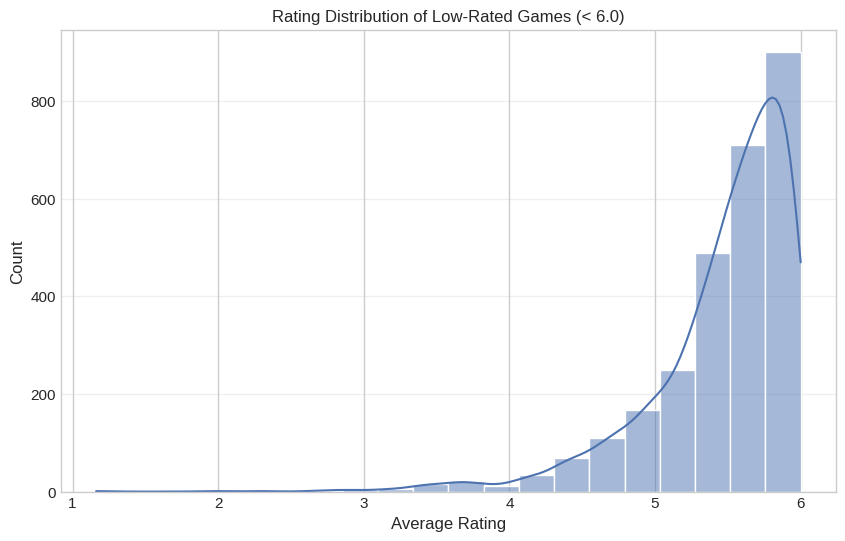

In [3]:
# Define low rating threshold
LOW_RATING_THRESHOLD = 6.0

# Filter for low-rated games
low_rated_games = filtered_df[filtered_df['AvgRating'] < LOW_RATING_THRESHOLD].copy()

print(f"Total games: {len(filtered_df)}")
print(f"Low-rated games (< {LOW_RATING_THRESHOLD}): {len(low_rated_games)}")
print(f"Percentage of original dataset: {len(low_rated_games) / len(filtered_df) * 100:.1f}%")
print(f"Mean: {low_rated_games['AvgRating'].mean():.3f}")

# Visualize rating distribution of low-rated games
plt.figure(figsize=(10, 6))
sns.histplot(low_rated_games['AvgRating'], bins=20, kde=True)
plt.title(f'Rating Distribution of Low-Rated Games (< {LOW_RATING_THRESHOLD})')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.savefig('../plots/low_rating_distribution.png')
plt.show()

# Cluster Low-Rated Games

In [4]:
# Perform clustering on low-rated games
try:
    print("\nClustering low-rated games...")
    best_params, pca_result, labels, scores, pca, n_components = agglomerative_grid_search(
        low_rated_games, all_binary_cols, variance_threshold=0.8, max_components=50
    )
    
    # Add cluster labels to low_rated_games
    low_rated_games['LowRatingCluster'] = labels
    
    print(f"\nClustering completed with {len(set(labels))} clusters")
    print(f"Best parameters: n_clusters={best_params[0]}, linkage={best_params[1]}, metric={best_params[2]}")
    print(f"Silhouette score: {scores['silhouette']:.4f}")
    print(f"Calinski-Harabasz score: {scores['ch_score']:.1f}")
    print(f"Davies-Bouldin score: {scores['db_score']:.4f}")
    
except Exception as e:
    print(f"Error in clustering: {e}")


Clustering low-rated games...
Using 50 PCA components (threshold would need 58)
Variance explained with 50 components: 0.7580

Grid search for Agglomerative Clustering parameters:
n_clusters=5, linkage=ward, metric=euclidean: silhouette=0.0588, CH=96.6, DB=2.9302
n_clusters=5, linkage=ward, metric=manhattan: Failed to calculate metrics
n_clusters=5, linkage=ward, metric=cosine: Failed to calculate metrics
n_clusters=5, linkage=complete, metric=euclidean: silhouette=0.0789, CH=28.8, DB=3.5383
n_clusters=5, linkage=complete, metric=manhattan: silhouette=0.0421, CH=24.1, DB=5.3600
n_clusters=5, linkage=complete, metric=cosine: silhouette=-0.0074, CH=55.3, DB=4.9900
n_clusters=5, linkage=average, metric=euclidean: silhouette=0.2763, CH=3.9, DB=0.9980
n_clusters=5, linkage=average, metric=manhattan: silhouette=0.2798, CH=3.6, DB=0.8548
n_clusters=5, linkage=average, metric=cosine: silhouette=0.0450, CH=84.0, DB=3.9063
n_clusters=5, linkage=single, metric=euclidean: silhouette=0.2758, CH=3.

# Visualize Clustering Results

In [ ]:
# Only create visualization if we have at least one cluster
n_clusters = len(set(labels))
if n_clusters > 0:
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        pca_result[:, 0], pca_result[:, 1], 
        c=labels, cmap='viridis', 
        alpha=0.6, s=30
    )
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'Low-Rated Board Game Clusters in PCA Space')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.savefig(f'../plots/clusters_2d_low_rated.png')
    plt.show()
    plt.close()

# Analyze Cluster Profiles

In [6]:
# Get cluster statistics
cluster_stats = low_rated_games.groupby('LowRatingCluster').agg({
    'BGGId': 'count',
    'AvgRating': ['mean', 'median', 'min', 'max', 'std']
}).reset_index()

# Flatten multi-level columns
cluster_stats.columns = ['LowRatingCluster', 'Count', 'AvgRating_Mean', 'AvgRating_Median', 
                        'AvgRating_Min', 'AvgRating_Max', 'AvgRating_Std']

# Sort by highest average rating
cluster_stats = cluster_stats.sort_values('AvgRating_Mean', ascending=False)

print("\nCluster statistics (sorted by average rating):")
print(cluster_stats)

# Function to get top features by prevalence
def get_top_features(df, feature_cols, n=5):
    feature_prevalence = {}
    for col in feature_cols:
        if col in df.columns:
            feature_name = col.split(':', 1)[1] if ':' in col else col
            feature_prevalence[feature_name] = df[col].mean() * 100
    
    # Sort by prevalence and get top n
    sorted_features = sorted(feature_prevalence.items(), key=lambda x: x[1], reverse=True)
    return sorted_features[:n]

# Print cluster profiles
print("\nCluster Profiles:")
for cluster_id in low_rated_games['LowRatingCluster'].unique():
    cluster_df = low_rated_games[low_rated_games['LowRatingCluster'] == cluster_id]
    
    # Get statistics
    stats = cluster_stats[cluster_stats['LowRatingCluster'] == cluster_id].iloc[0]
    
    print(f"\n==== Cluster {cluster_id} ====")
    print(f"Games: {len(cluster_df)} ({len(cluster_df) / len(low_rated_games) * 100:.1f}% of low-rated games)")
    print(f"Average Rating: {stats['AvgRating_Mean']:.2f} (min: {stats['AvgRating_Min']:.2f}, max: {stats['AvgRating_Max']:.2f})")
    
    # Top mechanics
    print("\nTop Mechanics:")
    for mechanic, prevalence in get_top_features(cluster_df, mechanics_cols):
        print(f"  {mechanic}: {prevalence:.1f}%")
    
    # Top themes
    print("\nTop Themes:")
    for theme, prevalence in get_top_features(cluster_df, themes_cols):
        print(f"  {theme}: {prevalence:.1f}%")
    
    # Top categories
    print("\nTop Categories:")
    for category, prevalence in get_top_features(cluster_df, category_cols, n=3):
        print(f"  {category}: {prevalence:.1f}%")

    # Top subcategories
    print("\nTop Subcategories:")
    for subcategory, prevalence in get_top_features(cluster_df, subcategories_cols, n=3):
        print(f"  {subcategory}: {prevalence:.1f}%")
    
    # Example games
    print("\nExample Games:")
    for _, game in cluster_df.sort_values('AvgRating', ascending=False).head(5).iterrows():
        print(f"  {game['Name']} ({game['YearPublished']}): {game['AvgRating']:.2f}")


Cluster statistics (sorted by average rating):
   LowRatingCluster  Count  AvgRating_Mean  AvgRating_Median  AvgRating_Min  AvgRating_Max  AvgRating_Std
3                 3     94        5.601346          5.695805        3.70837        5.99923       0.387719
1                 1    967        5.506503          5.625350        2.29913        5.99917       0.481059
4                 4    303        5.506293          5.614120        2.94677        5.99791       0.464498
0                 0   1374        5.418481          5.567130        1.16208        5.99987       0.540629
2                 2     53        5.161051          5.231660        3.58760        5.96255       0.496630

Cluster Profiles:

==== Cluster 4 ====
Games: 303 (10.9% of low-rated games)
Average Rating: 5.51 (min: 2.95, max: 6.00)

Top Mechanics:
  Dice Rolling: 44.9%
  Hand Management: 25.7%
  Variable Player Powers: 14.9%
  Roll / Spin and Move: 13.5%
  Modular Board: 11.6%

Top Themes:
  Fantasy: 51.5%
  Fighting: 37.3

# Decision Tree Analysis of Low-Rated Clusters

In [9]:
# For each cluster, build a decision tree to distinguish it from other clusters
for cluster_id in sorted(low_rated_games['LowRatingCluster'].unique()):
    # Create binary target: 1 for this cluster, 0 for other clusters
    y = (low_rated_games['LowRatingCluster'] == cluster_id).astype(int)
    X = low_rated_games[all_binary_cols]
    
    # Train a decision tree
    dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42)
    dt.fit(X, y)
    
    # Get feature importances
    importances = pd.DataFrame({
        'Feature': all_binary_cols,
        'Importance': dt.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Print top features
    print(f"\nTop features for identifying Cluster {cluster_id}:")
    for _, row in importances[importances['Importance'] > 0].head(10).iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
    
    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(
        dt, 
        feature_names=all_binary_cols, 
        class_names=[f'Other Clusters', f'Cluster {cluster_id}'],
        filled=True, 
        rounded=True,
        fontsize=10
    )
    plt.title(f'Decision Tree for Low-Rated Cluster {cluster_id}')
    plt.tight_layout()
    plt.savefig(f'../plots/low_rated_cluster_{cluster_id}_decision_tree.png')
    plt.show()


Top features for identifying Cluster 0:
  Card Game: 0.7172
  Cat:War: 0.1333
  Fantasy: 0.0849
  Science Fiction: 0.0264
  Economic: 0.0167
  Hexagon Grid: 0.0124
  Movies / TV / Radio theme: 0.0092

Top features for identifying Cluster 1:
  Card Game: 0.7139
  Dice Rolling: 0.0961
  Deduction: 0.0824
  Fighting: 0.0607
  Betting and Bluffing: 0.0406
  Drafting: 0.0063

Top features for identifying Cluster 2:
  Roll / Spin and Move: 0.5199
  Negotiation: 0.4643
  Player Elimination: 0.0136
  Auction/Bidding: 0.0017
  Trading: 0.0003

Top features for identifying Cluster 3:
  Cat:War: 0.8193
  Hexagon Grid: 0.1311
  Simulation: 0.0496

Top features for identifying Cluster 4:
  Fantasy: 0.5250
  Fighting: 0.3074
  Cat:Thematic: 0.1029
  Novel-based: 0.0307
  Cat:Strategy: 0.0306
  Dice Rolling: 0.0033


# Save Results

In [8]:
# Save low-rated games with cluster assignments
low_rated_games.to_csv('../frames/low_rated_games_with_clusters.csv', index=False)

# Create a cluster assignments DataFrame for integration with the main dataset
low_rating_clusters = pd.DataFrame({
    'BGGId': low_rated_games['BGGId'],
    'LowRatingCluster': low_rated_games['LowRatingCluster']
})

# Save cluster assignments
low_rating_clusters.to_csv('../frames/low_rating_clustering_assignments.csv', index=False)

# Save cluster statistics
cluster_stats.to_csv('../frames/low_rating_cluster_statistics.csv', index=False)

print(f"Saved clustering results for {len(low_rated_games)} low-rated games")

Saved clustering results for 2791 low-rated games
